In [9]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [10]:
output_path = "../output"

In [11]:
evaluations_file = "evaluations.json"
evaluations_path = os.path.join(output_path, evaluations_file)

In [12]:
with open(evaluations_path, "r") as file:
    evaluations = json.load(file)

In [13]:
evaluations_list = []

for model_name in evaluations:
    for scenario in evaluations[model_name]:
        for metric in evaluations[model_name][scenario]:
            line = {"model":model_name, 
                    "scenario":int(scenario), 
                    "metric":metric, 
                    "value":evaluations[model_name][scenario][metric]}
            evaluations_list.append(line)

evaluations_df = pd.DataFrame(evaluations_list)

In [14]:
model_names = ["0_mse", "0_mae", "1_mse", "1_mae", "2_mse", "2_mae"]
metrics = ["mae", "mse"]

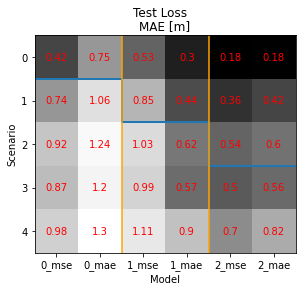

In [41]:
fig, ax = plt.subplots()

table = np.empty((6, 5))

for i_model in range(6):
    for scenario in range(5):
        mask = evaluations_df["metric"] == "mae"
        mask = np.bitwise_and(mask, evaluations_df["model"] == model_names[i_model])
        mask = np.bitwise_and(mask, evaluations_df["scenario"] == scenario)
        value = evaluations_df[mask]["value"].to_numpy()[0]

        table[i_model][scenario] = value

        ax.text(i_model, scenario, np.around(value, decimals=2),
                        ha="center", va="center", color="red")

table = table.T

plt.xticks(np.arange(6), model_names)

plt.plot([-0.5, 1.5, 1.5, 3.5, 3.5, 5.5], [0.5, 0.5, 1.5, 1.5, 2.5, 2.5], linewidth=2)
plt.plot([1.5,1.5], [-0.5,4.5], color="orange")
plt.plot([3.5, 3.5], [ -0.5,4.5], color="orange")

plt.suptitle("Test Loss")
plt.title("MAE [m]")
plt.xlabel("Model")
plt.ylabel("Scenario")
plt.imshow(table, cmap="Greys_r")
plt.show()

path = os.path.join(output_path, "TestLoss.png")
fig.savefig(path, facecolor="white", transparent=False)

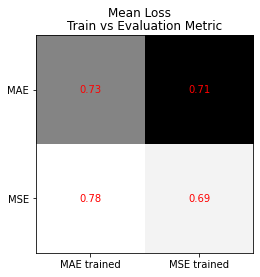

In [44]:
fig, ax = plt.subplots()

all_values = np.empty((2,2))

for i, metric in enumerate(metrics):
    
    mae = []
    mse = []
    for model_name in model_names:
        mask = evaluations_df["metric"] == metric
        mask = np.bitwise_and(mask, evaluations_df["model"] == model_name)
        values = evaluations_df[mask]["value"].to_numpy()
        
        if model_name[-3:] == "mae":
            mae.append(values)
            
        else:
            mse.append(values)

    mae = np.array(mae).mean()
    mse = np.array(mse).mean()
    
    all_values[0] = [mae, mse]

    text = ax.text(0, i, np.around(mae, decimals=2),
                        ha="center", va="center", color="red")

    text = ax.text(1, i, np.around(mse, decimals=2),
                        ha="center", va="center", color="red")

plt.suptitle("Mean Loss")
plt.title("Train vs Evaluation Metric")
plt.imshow(all_values, cmap="Greys_r")
plt.xticks([0, 1], ["MAE trained", "MSE trained"])
plt.yticks([0, 1], ["MAE", "MSE"])
plt.show()

path = os.path.join(output_path, "MeanLoss-TrainVsEvaluation.png")
fig.savefig(path, facecolor="white", transparent=False)

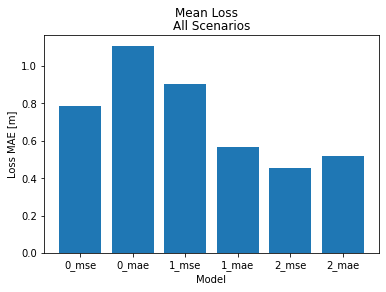

In [49]:
fig = plt.figure()
plt.suptitle("Mean Loss")
plt.title("All Scenarios")
plt.xlabel("Model")
plt.ylabel("Loss MAE [m]")

mean_per_model = table.mean(axis=0)
plt.bar(model_names, mean_per_model)

plt.show()

path = os.path.join(output_path, "MeanLoss-Scenarios.png")
fig.savefig(path, facecolor="white", transparent=False)

In [18]:
import glob

import torch
import wandb

from train.model import OAKD3DKeypoint
from train.dataset import SyntheticOAKDDataset
from train.dataset import coco2unity

DATASET_PATH = os.environ["USERPROFILE"]+"\\AppData\\LocalLow\\DefaultCompany\\IA904-3D_Pose\\solo"
DATASET_PATH = "I:\\.shortcut-targets-by-id\\1S6q0nt4z5LYa-5VkpC8qxag2b_jjO6e9\\IA904\\Dataset"

BASE_ARTIFACT_NAME = "eltoncn/IA904-OAKD3DKeypoint/model:{model_version}"
MODEL_VERSIONS = ["0_mse", "0_mae", "1_mse", "1_mae", "2_mse", "2_mae"]
SCENARIOS = [0, 1, 2, 3, 4]

convolutional_sizes = [10, 5]
dense_hidden_size = 50
dropout_rate = 0.2 #Not necessary

api = wandb.Api()

def get_model_path(model_version:str) -> str:
    artifact_name = BASE_ARTIFACT_NAME.format(model_version=model_version)
    artifact = api.artifact(artifact_name)
    artifact_dir = artifact.download()

    model_pattern = os.path.join(artifact_dir, "*.pth")
    paths = glob.glob(model_pattern)

    return paths[0]

def get_model(model_version:str) -> OAKD3DKeypoint:
    model_path = get_model_path(model_version)

    model = OAKD3DKeypoint([256, 192], convolutional_sizes, dense_hidden_size, dropout_rate)

    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    return model

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model("2_mse")
model.to(device);

wandb:   1 of 1 files downloaded.  


In [20]:
dataset = SyntheticOAKDDataset(DATASET_PATH, [4])
n_keypoint = len(coco2unity)

In [21]:
x_all = np.ones((n_keypoint, 3, 192, 256))
y_all = np.ones((n_keypoint, 3))

for i in range(n_keypoint):
    x, y = dataset.__getitem__(i+n_keypoint)
    
    x_all[i] = x
    y_all[i] = y


In [22]:

joints2index = dict(zip(list(coco2unity.keys()), list(range(17))))

connections = [["left_shoulder", "right_shoulder"], 
 ["left_hip", "right_hip"],
 ["left_shoulder", "left_hip"], ["right_shoulder", "right_hip"],
 ["left_hip", "left_knee"], ["right_hip", "right_knee"],
 ["left_ankle", "left_knee"], ["right_ankle", "right_knee"],
 ["left_shoulder", "left_elbow"], ["right_shoulder", "right_elbow"],
 ["left_wrist", "left_elbow"], ["right_wrist", "right_elbow"],
 ["nose", "left_eye"], ["nose", "right_eye"],
 ["left_ear", "left_eye"], ["right_ear", "right_eye"]]

In [28]:
x_batch = torch.tensor(x_all, dtype=torch.float32)
x_batch = x_batch.to(device)
predicted = model(x_batch)

In [30]:
y_pred = predicted.detach().cpu().numpy()

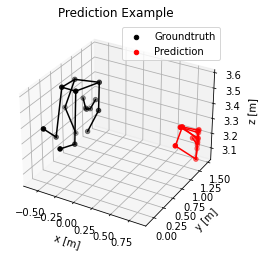

In [46]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ys = [y_all, y_pred]
colors = ["black", "red"]

for i in range(2):
    y = ys[i]
    color = colors[i]

    ax.scatter(y[:,0], y[:,1], y[:,2], color=color)


    for connection in connections:
        indexes = []
        for i in range(2):
            indexes.append(joints2index[connection[i]])

        ax.plot(y[indexes,0], y[indexes,1], y[indexes,2], color=color, label='_nolegend_')

plt.title("Prediction Example")
plt.legend(["Groundtruth", "Prediction"])
plt.xlabel("x [m]")
plt.ylabel("y [m]")
ax.set_zlabel("z [m]")

plt.show()

path = os.path.join(output_path, "PredictionExample.png")
fig.savefig(path, facecolor="white", transparent=False)